In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep

import ROOT
import hist

mpl.style.use(hep.style.ATLAS)

Welcome to JupyROOT 6.24/02


In [2]:
α = np.pi/3
λ_1 = 579.1e-9 ## [nm] Y
λ_2 = 404.7e-9 ## [nm] P
θ_0 = 1.5701
θ_1 = 2.6958
θ_2 = 2.7904

θ_m3 = 2.6773
θ_m4 = 2.7324
θ_m5 = 2.7651
θ_m6 = 2.7846

Δ_θ = 0.0005
σ_θ = Δ_θ/np.sqrt(3)

## Formula per generare due variabili correlate: correlazione tra A e B

Date A, B correlate, avremo che queste due devono essere generate con una dovuta correlazione, corrispondente ad un coeff. $\rho = -0.8735429136694745$. Considerando A generata secondo una distribuzione gaussiana $(A, \sigma_A)$, voglio ottenere valore di B correlato (ma sempre distribuito in modo random)

In [3]:
def computeAB(th_0, th_1, th_2):
    
    def n_i(th_i, th_0):
        return np.sin((th_i - th_0 + α)/2)/np.sin(α/2)
    A = (n_i(th_1, th_0)*λ_1**2 - n_i(th_2, th_0)*λ_2**2)/(λ_1**2 - λ_2**2)
    B = (n_i(th_1, th_0) - n_i(th_2, th_0))/(1/(λ_1**2) - 1/(λ_2**2))
    return A, B

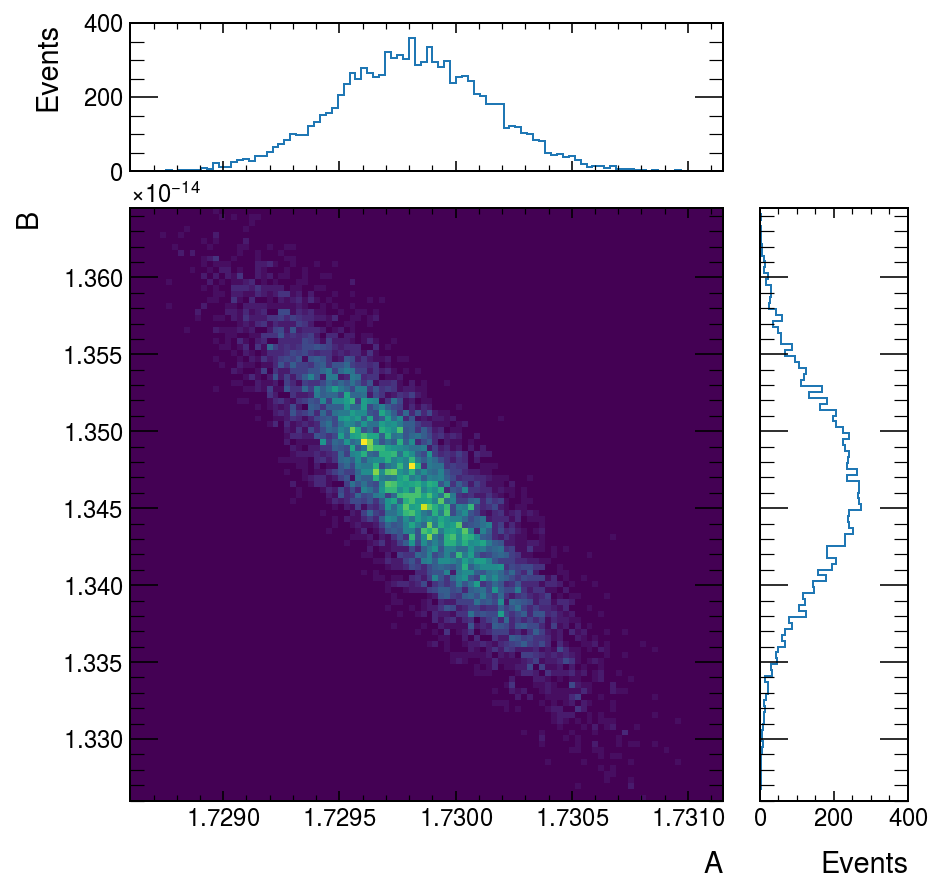

In [4]:
n_samples = 10_000

rnd = ROOT.TRandom3(58347942)

h_AB = ROOT.TH2D('', '', 100, 0, 0, 100, 0, 0)

for i in range(n_samples):
    A, B = computeAB(th_0=rnd.Gaus(θ_0,σ_θ), th_1=rnd.Gaus(θ_1,σ_θ), th_2=rnd.Gaus(θ_2,σ_θ))
    h_AB.Fill(A, B)

def plot_2d(hist, xlabel, ylabel):
    fig = plt.figure(figsize=(6,6))
    grid = fig.add_gridspec(2,2, width_ratios=(4, 1), height_ratios=(1, 4), left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.1, hspace=0.1)

    ax = fig.add_subplot(grid[1,0])
    hep.hist2dplot(hist, ax=ax, cbar=False)

    ax_x = fig.add_subplot(grid[0,0], sharex=ax)
    ax_y = fig.add_subplot(grid[1,1], sharey=ax)

    ax_x.tick_params(axis='x', labelbottom=False)
    ax_y.tick_params(axis='y', labelleft=False)

    hep.histplot(hist.ProjectionX(), yerr=False, ax=ax_x)
    hep.histplot(hist.ProjectionY(), yerr=False, ax=ax_y, orientation='horizontal')

    ax_x.set_ylabel('Events')
    ax_y.set_xlabel('Events')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
plot_2d(h_AB, 'A', 'B')

In [5]:
h_AB.GetCorrelationFactor()

-0.871813894867573

Conosco quindi i valori delle distribuzioni A, B che posso assumere essere gaussiane, trovo infatti

In [6]:
from uncertainties import ufloat
print(f'A = {ufloat(h_AB.ProjectionX().GetMean(), h_AB.ProjectionX().GetStdDev()):.3uS}')
μ_A, σ_A = h_AB.ProjectionX().GetMean(), h_AB.ProjectionX().GetStdDev()
print(f'B = {ufloat(h_AB.ProjectionY().GetMean(), h_AB.ProjectionY().GetStdDev()):.3uS}')
μ_B, σ_B = h_AB.ProjectionY().GetMean(), h_AB.ProjectionY().GetStdDev()

A = 1.729811(322)
B = 1.34626(580)e-14


Ottengo quindi che posso generare casualmente A, B, ottenendo la distribuzione

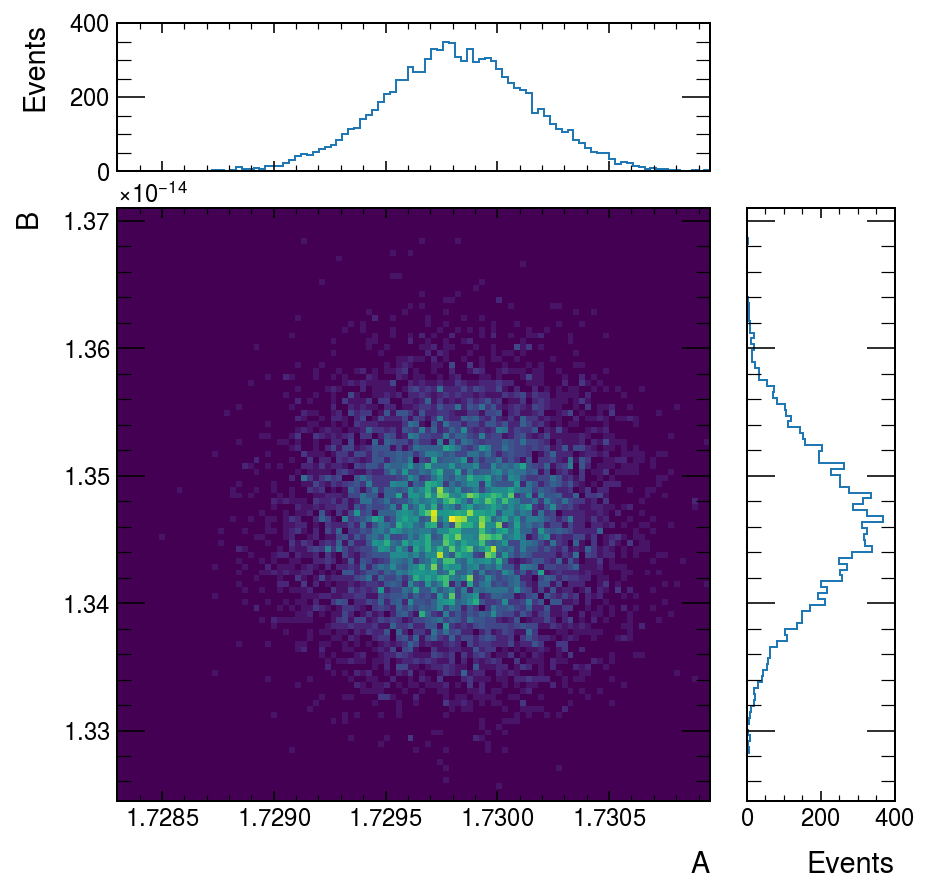

In [7]:
rnd = ROOT.TRandom3(45329095)

h_AB_normal = ROOT.TH2D('', '', 100, 0, 0, 100, 0, 0)

n_samples = 10_000
for _ in range(n_samples):
    h_AB_normal.Fill(rnd.Gaus(μ_A, σ_A), rnd.Gaus(μ_B, σ_B))

plot_2d(h_AB_normal, 'A', 'B')

Osserviamo che non si tratta della stessa distribuzione trovata sopra, quindi non è quello che stiamo cercando. 

-0.873927654695412

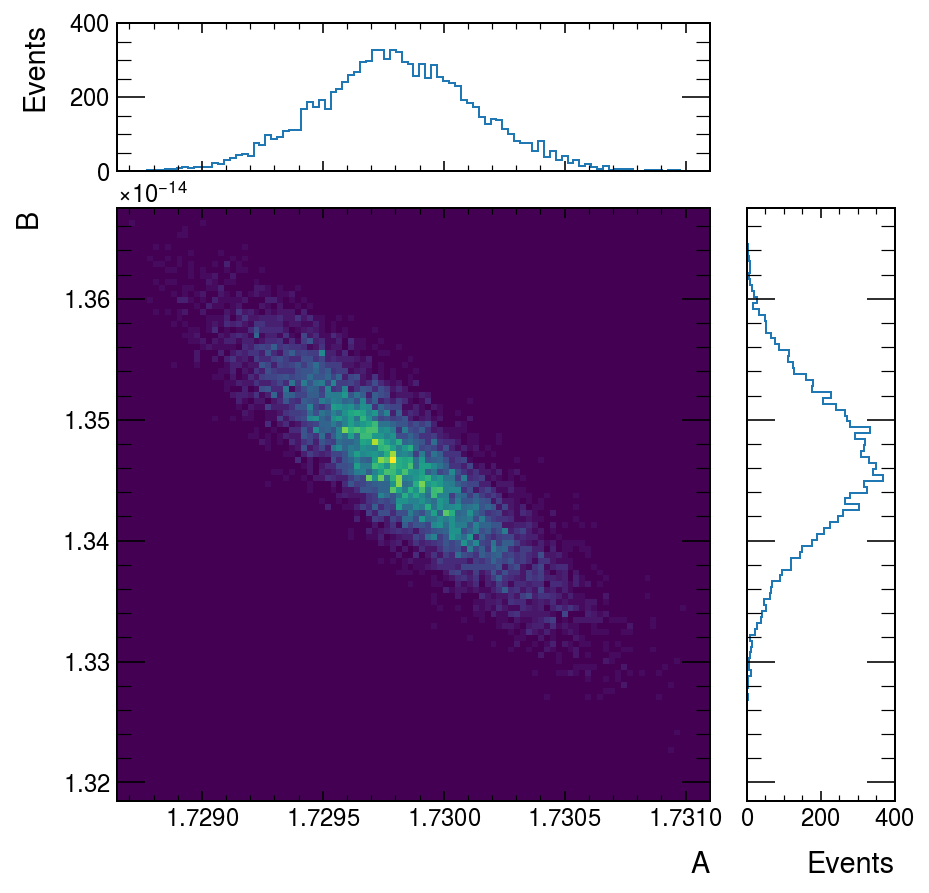

In [8]:
n_samples = 10_000
rnd = ROOT.TRandom3(45329095)

ρ = h_AB.GetCorrelationFactor()

h_AB_posterior = ROOT.TH2D('', '', 100, 0, 0, 100, 0, 0)

for _ in range(n_samples):
    X_1, X_2 = rnd.Gaus(), rnd.Gaus()
    A = μ_A + σ_A*(ρ*X_1+np.sqrt(1-ρ**2)*X_2)
    B = μ_B + σ_B*(X_1)
    h_AB_posterior.Fill(A, B)
    
plot_2d(h_AB_posterior, 'A', 'B')
h_AB_posterior.GetCorrelationFactor()

Utilizzo il valore ora trovato per capire come si comporta l'intero spettro generato. 

In [12]:
n_samples = 100_000

rnd = ROOT.TRandom3(27862456890)

h_λ = ROOT.TH1D('', '', 500, 400e-9, 700e-9)
h_λ_normal = ROOT.TH1D('', '', 500, 400e-9, 700e-9)

def over_λ(θ, θ_0, α, A, B):
    return ( 
        ( 
            np.sin( 
                (θ - θ_0 + α)/2 
            )/np.sin(α/2) - A 
        )/B
    )**0.5

θ = np.array([θ_m3, θ_m4, θ_m5, θ_m6])

for _ in range(n_samples):
    binomial = rnd.Rndm()
    
    def genAB(rnd = rnd):
        X_1, X_2 = rnd.Gaus(), rnd.Gaus()
        A = μ_A + σ_A*(ρ*X_1+np.sqrt(1-ρ**2)*X_2)
        B = μ_B + σ_B*(X_1)
        return A, B
    
    A, B = genAB()
    
    if binomial<=0.25 and binomial>=0:
        h_λ.Fill(1/over_λ(rnd.Gaus(θ_m3, σ_θ), rnd.Gaus(θ_0, σ_θ), α, A, B))
        h_λ_normal.Fill(1/over_λ(rnd.Gaus(θ_m3, σ_θ), rnd.Gaus(θ_0, σ_θ), α,  rnd.Gaus(A, σ_A), rnd.Gaus(B, σ_B)))
    elif binomial<=0.5 and binomial>0.25:
        h_λ.Fill(1/over_λ(rnd.Gaus(θ_m4, σ_θ), rnd.Gaus(θ_0, σ_θ), α, A, B))
        h_λ_normal.Fill(1/over_λ(rnd.Gaus(θ_m4, σ_θ), rnd.Gaus(θ_0, σ_θ), α,  rnd.Gaus(A, σ_A), rnd.Gaus(B, σ_B)))
    elif binomial<=0.75 and binomial>0.5:
        h_λ.Fill(1/over_λ(rnd.Gaus(θ_m5, σ_θ), rnd.Gaus(θ_0, σ_θ), α, A, B))
        h_λ_normal.Fill(1/over_λ(rnd.Gaus(θ_m5, σ_θ), rnd.Gaus(θ_0, σ_θ), α,  rnd.Gaus(A, σ_A), rnd.Gaus(B, σ_B)))
    else:
        h_λ.Fill(1/over_λ(rnd.Gaus(θ_m6, σ_θ), rnd.Gaus(θ_0, σ_θ), α, A, B))
        h_λ_normal.Fill(1/over_λ(rnd.Gaus(θ_m6, σ_θ), rnd.Gaus(θ_0, σ_θ), α,  rnd.Gaus(A, σ_A), rnd.Gaus(B, σ_B)))



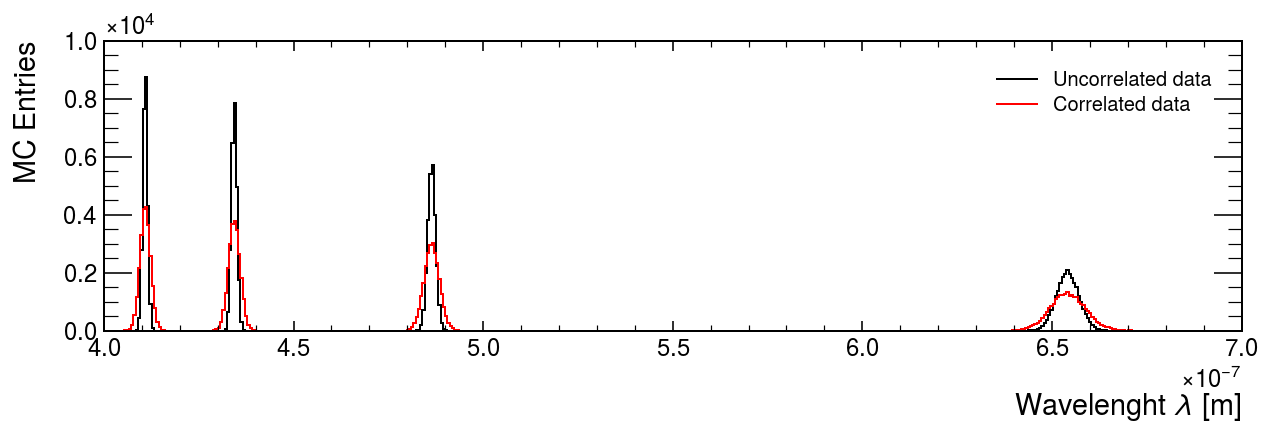

In [44]:
plt.figure(figsize=(10,2.5))
hep.histplot(h_λ,yerr=False,color='k', label='Uncorrelated data')
hep.histplot(h_λ_normal,yerr=False,color='r', label='Correlated data')

plt.legend()
plt.xlabel('Wavelenght $\lambda$ [m]', labelpad=15)
plt.ylabel('MC Entries')
plt.savefig('wavelenght.pdf', bbox_inches='tight')


Text(0, 1, 'Entries')

Warning in <TROOT::Append>: Replacing existing TH1: R_{H}^{m=3} (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: R_{H}^{m=4} (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: R_{H}^{m=5} (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: R_{H}^{m=6} (Potential memory leak).


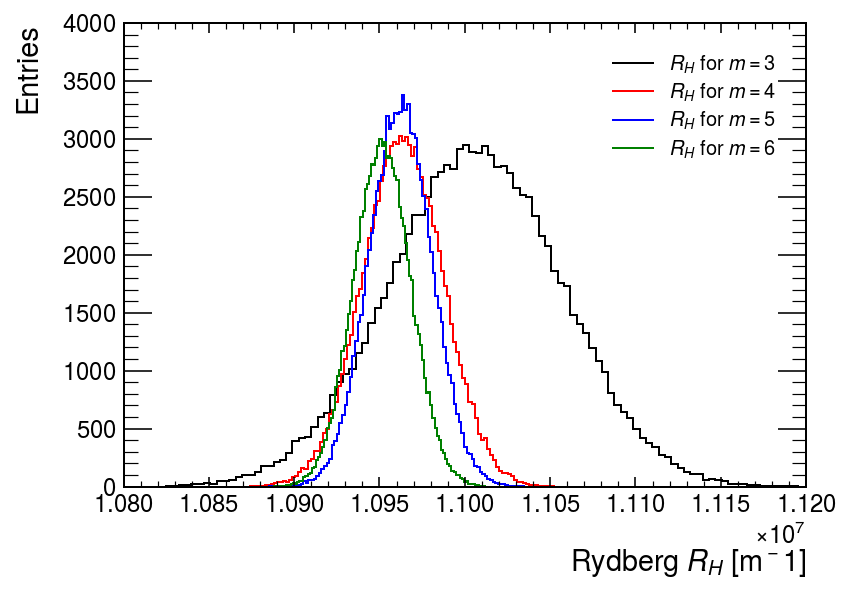

In [45]:
def getRH(overλ, m, n=2):
    def balmer(m = m, n=n):
        return 1/n**2 - 1/m**2
    
    return overλ/balmer(m,n)

n_samples = 100_000

rnd = ROOT.TRandom3(320358902)

h_RH_3 = ROOT.TH1D('R_{H}^{m=3}', '', 100, 0, 0)
h_RH_4 = ROOT.TH1D('R_{H}^{m=4}', '', 100, 0, 0)
h_RH_5 = ROOT.TH1D('R_{H}^{m=5}', '', 100, 0, 0)
h_RH_6 = ROOT.TH1D('R_{H}^{m=6}', '', 100, 0, 0)

for _ in range(n_samples):
    A, B = genAB()
    h_RH_3.Fill(getRH(over_λ(rnd.Gaus(θ_m3, σ_θ), rnd.Gaus(θ_0, σ_θ), α, A, B), 3))
    A, B = genAB()
    h_RH_4.Fill(getRH(over_λ(rnd.Gaus(θ_m4, σ_θ), rnd.Gaus(θ_0, σ_θ), α, A, B), 4))
    A, B = genAB()
    h_RH_5.Fill(getRH(over_λ(rnd.Gaus(θ_m5, σ_θ), rnd.Gaus(θ_0, σ_θ), α, A, B), 5))
    A, B = genAB()
    h_RH_6.Fill(getRH(over_λ(rnd.Gaus(θ_m6, σ_θ), rnd.Gaus(θ_0, σ_θ), α, A, B), 6))

fig, ax = plt.subplots()
hep.histplot(h_RH_3, color='k', yerr=False, label='$R_H$ for $m=3$', ax=ax)
hep.histplot(h_RH_4, color='r', yerr=False, label='$R_H$ for $m=4$', ax=ax)
hep.histplot(h_RH_5, color='b', yerr=False, label='$R_H$ for $m=5$', ax=ax)
hep.histplot(h_RH_6, color='g', yerr=False, label='$R_H$ for $m=6$', ax=ax)
ax.legend()
ax.set_xlabel('Rydberg $R_H$ [m$^-1$]', labelpad=15)
ax.set_ylabel('Entries')

In [46]:
fig.savefig('rydberg.pdf', bbox_inches='tight')

In [47]:
for i, rh in enumerate([h_RH_3, h_RH_4, h_RH_5, h_RH_6]):
    print(f'n = 2, m = {i+3}: R_H = {ufloat(rh.GetMean(), rh.GetStdDev()):.3uS}')

n = 2, m = 3: R_H = 1.10059(505)e+07
n = 2, m = 4: R_H = 1.09637(236)e+07
n = 2, m = 5: R_H = 1.09623(184)e+07
n = 2, m = 6: R_H = 1.09516(167)e+07


## Osservazioni

 - Non abbiamo considerato possibili correlazioni tra $A$, $B$ e $\theta_0$, ipotizzando che siano diversi (ipotesi sensata, ma non convincente)
 - Non abbiamo però ottenuto una stima del valore di $R_H$ date le tre distribuzioni. 
 - Le tre distribuzioni a occhio risultano compatibili con il valore teorico, ma bisogna vedere se varia questa stima aggiungendo il numero di eventi generati. 